In [1]:
import os
import random

#data
import pandas as pd

# math
import numpy as np

# plotting
from matplotlib import pyplot as plt

# Machine learning
import sklearn
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [2]:
# get the data set
df_train = pd.read_csv('../data/train_test_rmsd_values_featurized_w_sasa_without_bad_pairs.csv')
df_validate = pd.read_csv('../data/validation_rmsd_values_featurized_w_sasa_without_bad_pairs.csv')

In [3]:
# bin the data
df_train['binned_rmsd'] = 0
for index, rmsd in df_train[['rmsd']].itertuples():
    if rmsd < 2:
        df_train.at[index, 'binned_rmsd'] = 1

# bin the data
df_validate['binned_rmsd'] = 0
for index, rmsd in df_validate[['rmsd']].itertuples():
    if rmsd < 2:
        df_validate.at[index, 'binned_rmsd'] = 1

In [4]:
not_features = ['template', 'docked', 'rmsd', 'binned_rmsd', 'uniprot_id',
                'smiles_template', 'smiles_docked', 'mcs_smartsString',
                'group']
df_train_feats = df_train.drop(columns=not_features)
df_train_label = df_train[['binned_rmsd']]
df_validate_feats = df_validate.drop(columns=not_features)
df_validate_label = df_validate[['binned_rmsd']]

In [14]:
# use RandomForest for Classification
rf = RandomForestClassifier(max_depth=3, n_estimators=15,  class_weight="balanced")

rf.fit(df_train_feats.to_numpy(), np.ravel(df_train_label.to_numpy()))

report=sklearn.metrics.classification_report(y_true=np.ravel(df_validate_label.to_numpy()),
                                      y_pred=rf.predict(df_validate_feats.to_numpy()))
print('Random Forest with simple decision threshold at rmsd = 2 :')
print(report)

Random Forest with simple decision threshold at rmsd = 2 :
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3375
           1       0.58      0.78      0.67      1406

    accuracy                           0.77      4781
   macro avg       0.74      0.77      0.75      4781
weighted avg       0.80      0.77      0.78      4781



In [15]:
# use DecisionTree for Classification
dt = tree.DecisionTreeClassifier(max_depth=3, class_weight="balanced")

dt.fit(df_train_feats.to_numpy(), np.ravel(df_train_label.to_numpy()))

report=sklearn.metrics.classification_report(y_true=np.ravel(df_validate_label.to_numpy()),
                                      y_pred=rf.predict(df_validate_feats.to_numpy()))
print('Decision Tree with simple decision threshold at rmsd = 2 :')
print(report)

Decision Tree with simple decision threshold at rmsd = 2 :
              precision    recall  f1-score   support

           0       0.89      0.77      0.83      3375
           1       0.58      0.78      0.67      1406

    accuracy                           0.77      4781
   macro avg       0.74      0.77      0.75      4781
weighted avg       0.80      0.77      0.78      4781



In [20]:
# Now check if there is performance difference when not training with data points
# that are considered inconclusive

df_train_feats_without_inconclusives = df_train.loc[(df_train['rmsd']<2) | (df_train['rmsd']>3)].drop(columns=not_features)
df_train_label_without_inconclusives = df_train.loc[(df_train['rmsd']<2) | (df_train['rmsd']>3)][['binned_rmsd']]

In [28]:
# use RandomForest for Classification (not trained with data with rmsd between 2 and 3)
rf = RandomForestClassifier(max_depth=3, n_estimators=15,  class_weight="balanced")

rf.fit(df_train_feats_without_inconclusives.to_numpy(), np.ravel(df_train_label_without_inconclusives.to_numpy()))

report=sklearn.metrics.classification_report(y_true=np.ravel(df_validate_label.to_numpy()),
                                      y_pred=rf.predict(df_validate_feats.to_numpy()))
print('Random Forest with simple decision threshold at rmsd = 2 :')
print(report)

Random Forest with simple decision threshold at rmsd = 2 :
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      3375
           1       0.57      0.81      0.67      1406

    accuracy                           0.77      4781
   macro avg       0.74      0.78      0.74      4781
weighted avg       0.81      0.77      0.78      4781



In [37]:
# use DecisionTree for Classification (not trained with data with rmsd between 2 and 3)
dt = tree.DecisionTreeClassifier(max_depth=3, class_weight="balanced")

dt.fit(df_train_feats_without_inconclusives.to_numpy(), np.ravel(df_train_label_without_inconclusives.to_numpy()))

report=sklearn.metrics.classification_report(y_true=np.ravel(df_validate_label.to_numpy()),
                                      y_pred=rf.predict(df_validate_feats.to_numpy()))
print('Decision Tree with simple decision threshold at rmsd = 2 :')
print(report)

Decision Tree with simple decision threshold at rmsd = 2 :
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      3375
           1       0.57      0.81      0.67      1406

    accuracy                           0.77      4781
   macro avg       0.74      0.78      0.74      4781
weighted avg       0.81      0.77      0.78      4781



In [53]:
tops = [1,2,3]
range_of_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
proportion_top = []
range_of_top = [1,2,3,4,5,6,7,8,9,10]
proportion_thresh = {top:[] for top in tops}
valids_thresh = {top:[] for top in tops}


test = df_validate
test['dt_score'] = list(rf.predict_proba(df_validate_feats.to_numpy())[:,1])

_proportion = []
for i in range_of_top:
    count = 0
    for docked in test['docked'].drop_duplicates().values:
            if test.loc[(test['docked']==docked)] \
                                 .sort_values(by=['dt_score'], ascending=False)[:i] \
                                 .loc[test['rmsd']<2.5].shape[0] > 0:
                count += 1
    #_proportion += [count/test[test['rmsd']<2]['docked'].drop_duplicates().shape[0]]#test['docked'].drop_duplicates().shape[0]]
    _proportion += [count/test['docked'].drop_duplicates().shape[0]]
proportion_top += [_proportion]

for top in tops:
    _proportion = []
    _valids = []
    for i in range_of_thresholds:
        count = 0
        valid = 0
        for docked in test['docked'].drop_duplicates().values:
            if test.loc[(test['docked']==docked) & (test['rmsd']>-1)].shape[0] > 0:
                if test.loc[(test['docked']==docked)
                                          & (test['dt_score']>i)].shape[0] > 0:
                    valid += 1
                    if test.loc[(test['docked']==docked) & (test['dt_score']>i)] \
                                         .sort_values(by=['dt_score'], ascending=False)[:top] \
                                         .loc[test['rmsd']<2.5].shape[0] > 0:
                        count += 1
        #_valids += [valid/test[test['rmsd']<2]['docked'].drop_duplicates().shape[0]]#test['docked'].drop_duplicates().shape[0]]
        _valids += [valid/test['docked'].drop_duplicates().shape[0]]
        if valid == 0:
            _proportion += [0]
        else:
            _proportion += [count/valid]
    proportion_thresh[top] += [_proportion]
    valids_thresh[top] += [_valids]

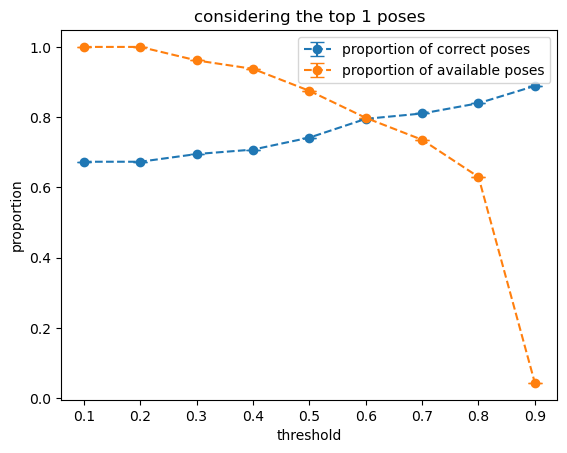

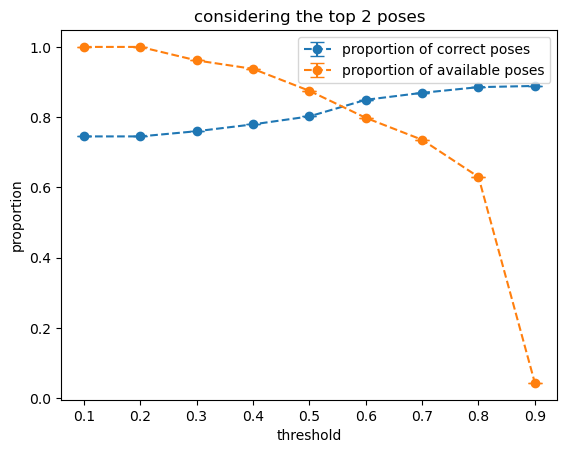

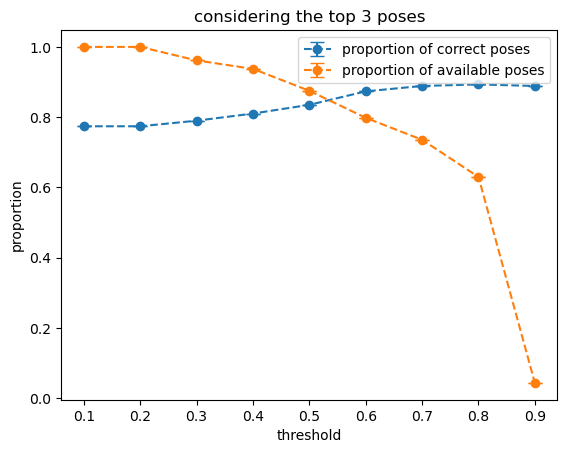

In [54]:
plt.style.use('default')
for top in tops:
    mean_proportion_thresh = []
    mean_valids_thresh = []
    std_proportion_thresh = []
    std_valids_thresh = []
    for i in range(len(range_of_thresholds)):
        mean_proportion_thresh += [np.mean(np.array(proportion_thresh[top])[:,i])]
        mean_valids_thresh += [np.mean(np.array(valids_thresh[top])[:,i])]
        std_proportion_thresh += [np.std(np.array(proportion_thresh[top])[:,i])]
        std_valids_thresh += [np.std(np.array(valids_thresh[top])[:,i])]

    plt.errorbar(range_of_thresholds, mean_proportion_thresh, yerr=std_proportion_thresh, capsize=5, fmt='--o', label='proportion of correct poses')
    plt.errorbar(range_of_thresholds, mean_valids_thresh, yerr=std_valids_thresh, capsize=5, fmt='--o', label='proportion of available poses')
    plt.xlabel('threshold')
    plt.ylabel('proportion')
    #plt.ylim([0.5,1.1])
    plt.title('considering the top '+str(top)+' poses')
    plt.legend()
    plt.show()